<a href="https://colab.research.google.com/github/BillWorstell/BaF2_LAPPD/blob/main/SimpleOpticsZPencil.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Generate a series of event along a single x and y within a miniblock, but with z position varying from 0 to DZ in 1000 steps

Import Pytorch

In [1]:
import torch
print(torch.__version__)
torch.manual_seed(42)

2.1.0+cu118


Import numpy, matplotlib, and icecream

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib import cm

!pip install icecream
from icecream import ic

Pytorch script below generates N photons per tensor for M events, gat random isotropic spherical angles. Emission is from a single line [x,y] in space, with emission time t_emit=0, specified here. Events can be generate either randomly in Z or regularly across a range

.

RegularZ::

   True -> monotonically increasing Z,

   False-> random

in either case distributed over entire  [0:DZ] Z range.

In [3]:
# Isotopic Emission from this point – origin at geometric center of MiniBlock
# CallSimpleOpticsPhotons = Script to generate photon lists
#
NEvents=1000
#NEvents=100
NPhotons=10000
#NPhotons=1024
#NPhotons=100
ic(NEvents)
SqrtNPhotons=int(np.sqrt(NPhotons))
ic(SqrtNPhotons)
#
# Switch to either have regular or random distribution of ZSource Positions
#RegularZ=False
RegularZ=True
#
# Define the ranges for source emission
XBounds= [1.5, 1.5]
YBounds=[-3.0,-3.0]
ZBounds=[0,45.]

ic(XBounds)
ic(YBounds)
ic(ZBounds)
#
# Distribute events uniformly over 3D range, with a common
#  emission point for all photons in an event
SourceX0=XBounds[0]+(XBounds[1]-XBounds[0])*torch.rand(NEvents)
SourceX=SourceX0.repeat_interleave(NPhotons)
SourceX=torch.reshape(SourceX,[NEvents,NPhotons])
SourceY0=YBounds[0]+(YBounds[1]-YBounds[0])*torch.rand(NEvents)
SourceY=SourceY0.repeat_interleave(NPhotons)
SourceY=torch.reshape(SourceY,[NEvents,NPhotons])
SourceZ0=ZBounds[0]+(ZBounds[1]-ZBounds[0])*torch.rand(NEvents)
SourceZ=SourceZ0.repeat_interleave(NPhotons)
SourceZ=torch.reshape(SourceZ,[NEvents,NPhotons])

XSource=SourceX
YSource=SourceY
ZSource=SourceZ

ic(RegularZ)
if RegularZ:
  ZFrac=torch.arange(0.,NEvents)/NEvents
  ZSource1D=ZBounds[0]+(ZFrac*(ZBounds[1]-ZBounds[0]))
  ZSource=ZSource1D.repeat_interleave(NPhotons)
  ZSource=torch.tensor(ZSource.reshape(NEvents,NPhotons))

#
ic(XSource.size())
ic(YSource.size())
ic(ZSource.size())
ic(XSource[0][0])
ic(YSource[0][0])
ic(ZSource[0][0])
ic(ZSource[0][1])
ic(ZSource[1][0])

ic| NEvents: 1000
ic| SqrtNPhotons: 100
ic| XBounds: [1.5, 1.5]
ic| YBounds: [-3.0, -3.0]
ic| ZBounds: [0, 45.0]
ic| RegularZ: True
<ipython-input-3-b5c68a0a725b>:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ZSource=torch.tensor(ZSource.reshape(NEvents,NPhotons))
ic| XSource.size(): torch.Size([1000, 10000])
ic| YSource.size(): torch.Size([1000, 10000])
ic| ZSource.size(): torch.Size([1000, 10000])
ic| XSource[0][0]: tensor(1.5000)
ic| YSource[0][0]: tensor(-3.)
ic| ZSource[0][0]: tensor(0.)
ic| ZSource[0][1]: tensor(0.)
ic| ZSource[1][0]: tensor(0.0450)


tensor(0.0450)

Parametrize Detector Optics

In [4]:
# Index of refraction for optical barriers
#  (Air and LIOB=Laser Induced Optical Barrier)
IndexX=1.0
IndexY=1.40
#Number of photons to generate (511 keV x ideal photosensor)
NFast=172.
NSlow=1059.
# Index of refraction for fast and slow component
IndexFastBaF2=1.55
IndexSlowBaF2=1.50
# Reflectivity of mirrored surfaces
ReflectX=0.90
ReflectY=0.90
ReflectZ=0.90

Parametrize Detector Geometry

In [5]:
#Constant Geometry Parameters
DZ = 45. #mm
DetectNX = 8
dX = 3.0  #mm
DX = DetectNX * dX
XBins=torch.arange(-DX/2.,DX/2.,dX)+(dX/2.)
ic(XBins)
DetectNY = 12;
dY = 2.0; #mm
DY = DetectNY  * dY
YBins=torch.arange(-DY/2.,DY/2.,dY)+(dY/2.)
ic(YBins)
TMax=1000. #Maximum Time in ps

ic| XBins: tensor([-10.5000,  -7.5000,  -4.5000,  -1.5000,   1.5000,   4.5000,   7.5000,
                    10.5000])
ic| YBins: tensor([-11.,  -9.,  -7.,  -5.,  -3.,  -1.,   1.,   3.,   5.,   7.,   9.,  11.])


Set up for multiple passes over different emission species with different intensities and lifetimes - artificial ideal material with arbitrary intensity and zero collection time for now.

Get critical angles at optical interfaces based on optical indices.

In [6]:
photon_passes = {'Fast': (NFast, IndexFastBaF2), 'Slow': (NSlow, IndexSlowBaF2)}

#for iPhotonPass in ['Fast','Slow']:
for iPhotonPass in ['Fast']:
    NPEs, Index = photon_passes[iPhotonPass]
    CMMPerPs = 0.3/Index
    #
    # Calculate critical angle for total internal reflection at interface
    SinThetaCriticalX=torch.tensor(IndexX/Index)
    SinThetaCriticalY=torch.tensor(IndexY/Index)
ic(Index)
ic(CMMPerPs)
ic(SinThetaCriticalX)
ic(SinThetaCriticalY)

ic| Index: 1.55
ic| CMMPerPs: 0.1935483870967742
ic| SinThetaCriticalX: tensor(0.6452)
ic| SinThetaCriticalY: tensor(0.9032)


tensor(0.9032)

Generate a random isotropic distribution of spherical angles.

In [7]:
NBins=np.ceil(np.sqrt(NPhotons))
NBins=int(np.round(2.*(np.ceil(NBins/2.))))
#

# Random isotropic distributions for all photons, all events
CosZSample=1.-2.*torch.rand(NEvents,NPhotons)
torch.pi = torch.acos(torch.zeros(1)).item() * 2 # which is 3.1415927410125732
PhiSample=2.*torch.pi*torch.rand(NEvents,NPhotons)

This code uses RandomAngles option only.

In [8]:
R = torch.sqrt(1.-torch.square(CosZSample))
vX = CMMPerPs * R * torch.cos(PhiSample)
vY = CMMPerPs * R * torch.sin(PhiSample)
vZ = CMMPerPs * CosZSample
SinTheta=CosZSample
SinPhi=torch.sin(PhiSample)
ic(R.size())
ic(vX.size())
ic(vY.size())
ic(vZ.size())
ic(SinTheta.size())
ic(SinPhi.size())

ic| R.size(): torch.Size([1000, 10000])
ic| vX.size(): torch.Size([1000, 10000])
ic| vY.size(): torch.Size([1000, 10000])
ic| vZ.size(): torch.Size([1000, 10000])
ic| SinTheta.size(): torch.Size([1000, 10000])
ic| SinPhi.size(): torch.Size([1000, 10000])


torch.Size([1000, 10000])

For Specular Optics, the vertical component of the velocity determines the collection time. The kinematics is separable in each dimension, and the velocity components change sign but not magnitude at reflection interfaces. Photons with upward z velocity component are reflected off the upper Z mirror.

We thus have an isometric (1-to-1) relation between emission directions for the photon and photon list outcomes, enabling us to randomly sample photons with the correct statistics including all correlations.

In [9]:
#Clip to remove division by zero
vZ=torch.where(torch.abs(vZ)>0.0000001,vZ,0.0000001)

ic(ZSource.size())
ic(vZ.size())

TTop=torch.divide(((2.*DZ)-ZSource),vZ)
TBottom=torch.divide(((0.*DZ)-ZSource),vZ)
TCollect=torch.maximum(TTop,TBottom)
vXCollect=XSource +torch.multiply(vX,TCollect)
vYCollect=YSource +torch.multiply(vY,TCollect)
ic(TTop.size())
ic(TBottom.size())
ic(TCollect.size())
ic(vXCollect.size())
ic(vYCollect.size())

TCollect=torch.maximum(torch.tensor(0.000001),TCollect)
TCollect=torch.minimum(torch.tensor(TMax),TCollect)
ic(TCollect.size())
ic(TCollect.median())
ic(TCollect.min())
ic(TCollect.amax())


ic| ZSource.size(): torch.Size([1000, 10000])
ic| vZ.size(): torch.Size([1000, 10000])
ic| TTop.size(): torch.Size([1000, 10000])
ic| TBottom.size(): torch.Size([1000, 10000])
ic| TCollect.size(): torch.Size([1000, 10000])
ic| vXCollect.size(): torch.Size([1000, 10000])
ic| vYCollect.size(): torch.Size([1000, 10000])
ic| TCollect.size(): torch.Size([1000, 10000])
ic| TCollect.median(): tensor(465.1422)
ic| TCollect.min(): tensor(1.0000e-06)
ic| TCollect.amax(): tensor(1000.)


tensor(1000.)

ic| npTCollect.shape: (1000, 10000)
ic| npZSource.shape: (1000, 10000)
ic| TCollectTMin.shape: (1000,)
ic| ITCollectTMin.shape: (1000,)
ic| ZSourceTMin.size: 1000


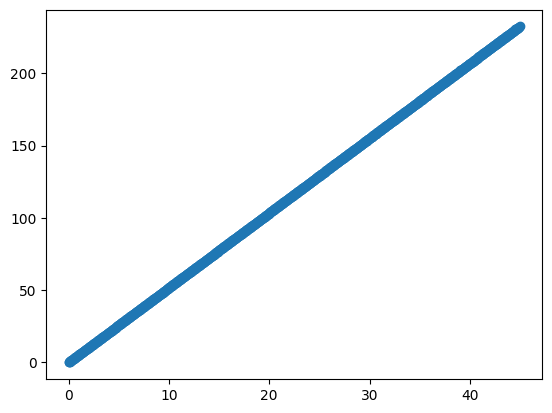

In [10]:
#TCollect0=TCollect[0,:].numpy()
#DT=1000.
#dT=50.
#TCollectBins=np.arange(0,DT,dT)
#plt.hist(TCollect0.flatten(), bins=TCollectBins)
#plt.title("First Event" )
#plt.xlabel("TCollect0 ps UnWeighted")
#plt.show()

npTCollect=np.reshape(TCollect.numpy(),[NEvents,NPhotons])
ic(npTCollect.shape)
npZSource=np.reshape(ZSource.numpy(),[NEvents,NPhotons])
ic(npZSource.shape)

TCollectTMin=np.min(npTCollect,axis=1)
ic(TCollectTMin.shape)

#ITCollectTMin=np.squeeze(TCollectTMin,axis=1)
ITCollectTMin=np.amin(npTCollect,axis=1).astype(int)
ic(ITCollectTMin.shape)

ZSourceTMin=np.zeros(NEvents)
for iEvent in range(NEvents):
  ZSourceTMin[iEvent]=npZSource[iEvent][ITCollectTMin[iEvent] ]

ic(ZSourceTMin.size)
plt.scatter(ZSourceTMin,TCollectTMin)
plt.show()

Determine which photons will undergo total internal reflection at each of the interfaces, and the total number reflections in both x and y directions for each photon.

In [11]:
photon_passes = {'Fast': (NFast, IndexFastBaF2), 'Slow': (NSlow, IndexSlowBaF2)}

#for iPhotonPass in ['Fast','Slow']:

# Calculate critical angle for total internal reflection at interface
# Set up data structures for 6 different reflection type cases
# depending on signs of VX, VY, snf vZ. Indices of medium and reflector then
# provide critical angle for this reflection to be total internal
#
# Condition for total internal reflection off X or Y planes
TIRX=torch.abs(SinTheta)>torch.abs(SinThetaCriticalX)
TIRY=torch.abs(SinTheta)>torch.abs(SinThetaCriticalY)
ic(TIRX.size())
ic(TIRY.size())
#
#Distance between reflections
DReflectX=torch.where(TIRX,dX,DX)
DReflectY=torch.where(TIRY,dY,DY)
ic(DReflectX.size())
ic(DReflectY.size())
#
#Unfold hall of mirrors into virtual detector
# Virtual detector collection ray lengths
DVXCollect=torch.abs(vX)*TCollect
DVYCollect=torch.abs(vY)*TCollect
ic(DVXCollect.size())
ic(DVYCollect.size())
#
# Number Reflections
NXReflect=torch.floor(DVXCollect/DReflectX)
NYReflect=torch.floor(DVYCollect/DReflectY)
ic(NXReflect.size())
ic(NYReflect.size())
#


ic| TIRX.size(): torch.Size([1000, 10000])
ic| TIRY.size(): torch.Size([1000, 10000])
ic| DReflectX.size(): torch.Size([1000, 10000])
ic| DReflectY.size(): torch.Size([1000, 10000])
ic| DVXCollect.size(): torch.Size([1000, 10000])
ic| DVYCollect.size(): torch.Size([1000, 10000])
ic| NXReflect.size(): torch.Size([1000, 10000])
ic| NYReflect.size(): torch.Size([1000, 10000])


torch.Size([1000, 10000])

Use infinite mirror isometries to map from a virtual system tiling the plane with a double layer of reflected unit cells onto the real system detection coordinates in X and Y.

Generate Reflection Survival Probabilies based on the number of reflections off each type of interface.

In [12]:
#
# Local emission coordinates within unit cell with origin at cell center
X0=torch.remainder(XSource+(DX/2.),DReflectX)-(DX/2.)
Y0=torch.remainder(YSource+(DY/2.),DReflectY)-(DY/2.)
ic(X0.size())
ic(Y0.size())
#
# Check whether first reflection is before being detected
TFirstX=torch.where(vX>0,np.divide((DReflectX/2.)-X0,vX),torch.divide(X0-(DReflectX/2.),vX))
TFirstY=torch.where(vY>0,np.divide((DReflectY/2.)-Y0,vY),torch.divide(Y0-(DReflectY/2.),vY))
ic(TFirstX.size())
ic(TFirstY.size())
#
# If there is a reflection before detection, increment the Reflection counter
NXReflect=torch.where(TCollect<TFirstX,NXReflect,NXReflect+1)
NYReflect=torch.where(TCollect<TFirstY,NYReflect,NYReflect+1)
ic(NXReflect.size())
ic(NYReflect.size())
#
# Get Reflection Survival Probability
# Reflectivity of mirrored surfaces
SurviveXReflect=torch.where(TIRX,1.,torch.pow(ReflectX,NXReflect))
SurviveYReflect=torch.where(TIRY,1.,torch.pow(ReflectY,NYReflect))
SurviveZReflect=torch.where(vZ>0,ReflectZ,1.)
SurviveReflect =torch.multiply(torch.multiply(SurviveXReflect,SurviveYReflect),SurviveZReflect)
ic(SurviveXReflect.size())
ic(SurviveYReflect.size())
ic(SurviveZReflect.size())
ic(SurviveReflect.size())


ic| X0.size(): torch.Size([1000, 10000])
ic| Y0.size(): torch.Size([1000, 10000])
<ipython-input-12-a6e832a016d8>:10: RuntimeWarning: divide by zero encountered in divide
  TFirstY=torch.where(vY>0,np.divide((DReflectY/2.)-Y0,vY),torch.divide(Y0-(DReflectY/2.),vY))
ic| TFirstX.size(): torch.Size([1000, 10000])
ic| TFirstY.size(): torch.Size([1000, 10000])
ic| NXReflect.size(): torch.Size([1000, 10000])
ic| NYReflect.size(): torch.Size([1000, 10000])
ic| SurviveXReflect.size(): torch.Size([1000, 10000])
ic| SurviveYReflect.size(): torch.Size([1000, 10000])
ic| SurviveZReflect.size(): torch.Size([1000, 10000])
ic| SurviveReflect.size(): torch.Size([1000, 10000])


torch.Size([1000, 10000])

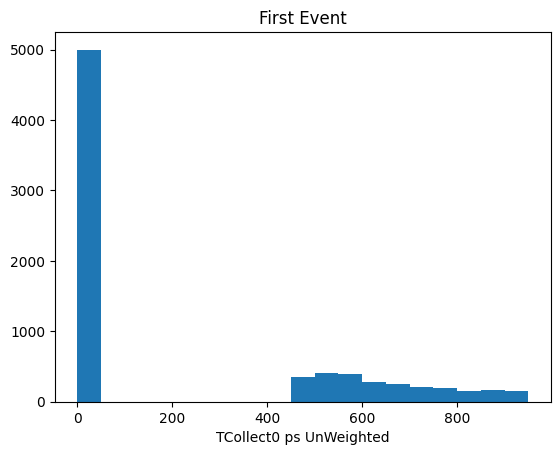

In [13]:
TCollect0=TCollect[0,:].numpy()
TMax=1000

TCollectBins=np.arange(0,TMax,50)
plt.hist(TCollect0.flatten(), bins=TCollectBins)
plt.title("First Event" )
plt.xlabel("TCollect0 ps UnWeighted")
plt.show()


RegularZ::

   True -> monotonically increasing Z,

   False-> random

in either case distributed over entire  [0:DZ] Z range.

.

If regular rather than random ZSource over events, plot mean survival probability as a function of ZSource

ic| 'RegularZ'


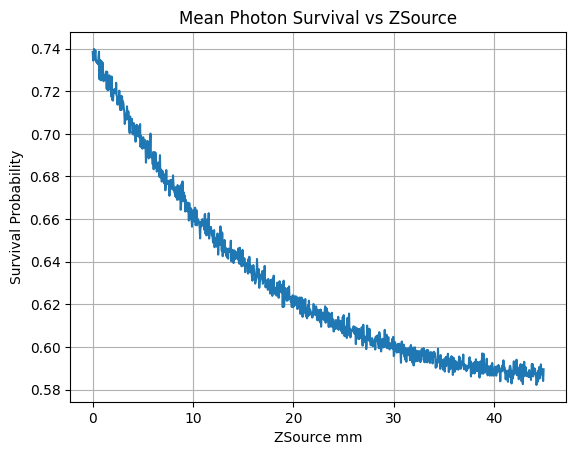

In [14]:
if (RegularZ==True):
  ic("RegularZ")
  MeanSurviveReflect=torch.mean(SurviveReflect,1)
  plt.plot(ZSource[:,0],MeanSurviveReflect)
  plt.xlabel('ZSource mm')
  plt.ylabel('Survival Probability')
  plt.title('Mean Photon Survival vs ZSource')
  plt.grid()

In [15]:
if (RegularZ==False):
  ic("RegularZ")
  MeanSurviveReflect=torch.mean(SurviveReflect,1)
  plt.scatter(ZSource[:,0],MeanSurviveReflect)
  plt.xlabel('Random ZSource mm')
  plt.ylabel('Survival Probability')
  plt.title('Mean Photon Survival vs ZSource')
  plt.grid()

If regular rather than random ZSource over events, plot mean number of X and Y reflections vs ZSource

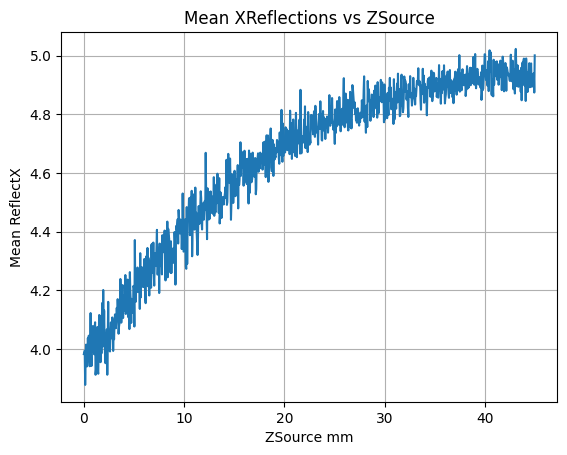

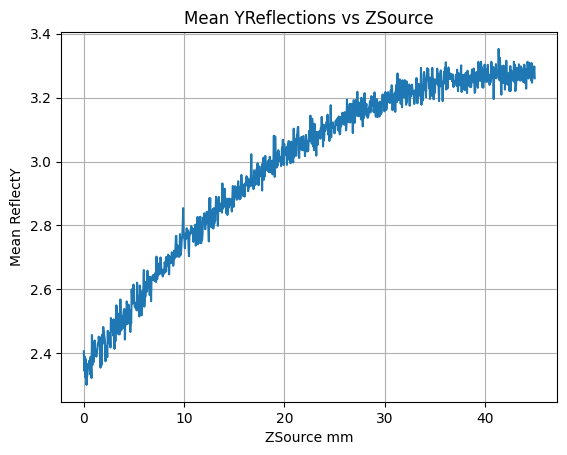

In [16]:
if (RegularZ):
  MeanReflectX=torch.mean(NXReflect,1)
  plt.plot(ZSource[:,0],MeanReflectX)
  plt.xlabel('ZSource mm')
  plt.ylabel('Mean ReflectX')
  plt.title('Mean XReflections vs ZSource')
  plt.grid()
  plt.show()

  MeanReflectY=torch.mean(NYReflect,1)
  plt.plot(ZSource[:,0],MeanReflectY)
  plt.xlabel('ZSource mm')
  plt.ylabel('Mean ReflectY')
  plt.title('Mean YReflections vs ZSource')
  plt.grid()
  plt.show()

If regular rather than random ZSource over events, plot mean and sigma of TCollect vs ZSource

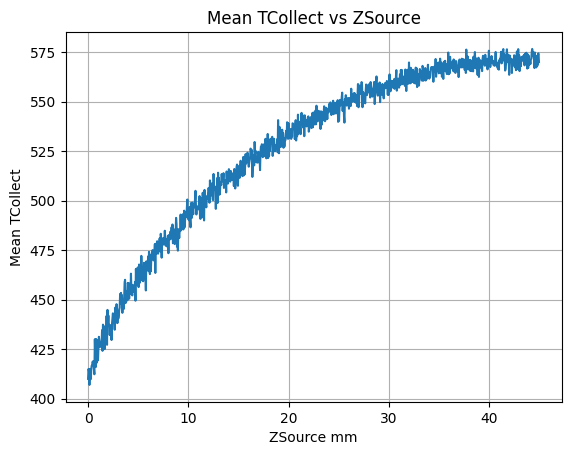

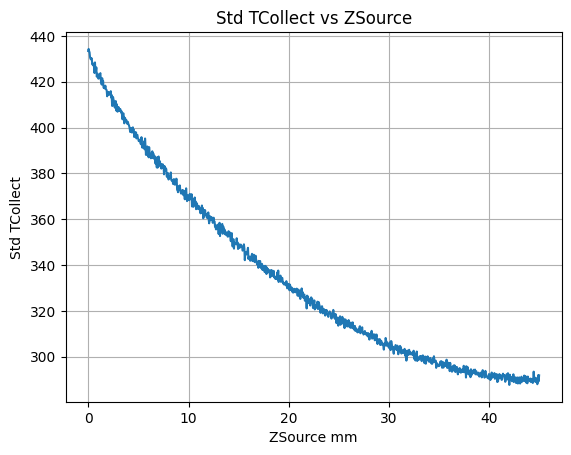

In [17]:
if (RegularZ):
  MeanTCollect=torch.mean(TCollect,1)
  plt.plot(ZSource[:,0],MeanTCollect)
  plt.xlabel('ZSource mm')
  plt.ylabel('Mean TCollect')
  plt.title('Mean TCollect vs ZSource')
  plt.grid()
  plt.show()

  StdTCollect=torch.std(TCollect,1)
  plt.plot(ZSource[:,0],StdTCollect)
  plt.xlabel('ZSource mm')
  plt.ylabel('Std TCollect')
  plt.title('Std TCollect vs ZSource')
  plt.grid()
  plt.show()

Perform parallel calculations for all the photon list entries for all the events, and print out the first event photon list attributes for a specified sample photon [debugging tool]

Find detection point in virtual detector within a reflected virtual unit cell, then map back onto real detection point within a real unit cell.

Size of unit cell depends upon whether or not total internal reflection in each direction.

All photon list parameters values for the specified test photon are displayed, for the first event.



In [18]:
photon_passes = {'Fast': (NFast, IndexFastBaF2), 'Slow': (NSlow, IndexSlowBaF2)}
for iPhotonPass in ['Fast']:
  NPEs, Index = photon_passes[iPhotonPass]
  NPEs=NPhotons

print("NPEs=",NPEs)
print("Index=",Index)
# Calculate critical angle for total internal reflection at interface
SinThetaCriticalX=IndexX/Index
print("SinThetaCriticalX=",SinThetaCriticalX)
SinThetaCriticalY=IndexY/Index
print("SinThetaCriticalY=",SinThetaCriticalY)
# Set up data structures for 6 different reflection type cases
# depending on signs of VX, VY, snf vZ. Indices of medium and reflector then
# provide critical angle for this reflection to be total internal
#
# Condition for total internal reflection off X or Y planes
TIRX=torch.abs(SinTheta)>torch.abs(torch.tensor(SinThetaCriticalX))
TIRY=torch.abs(SinTheta)>torch.abs(torch.tensor(SinThetaCriticalY))
#
#Distance between reflections
DReflectX=torch.where(TIRX,dX,DX)
DReflectY=torch.where(TIRY,dY,DY)
#
#Unfold hall of mirrors into virtual detector
# Virtual detector collection ray lengths
DVXCollect=torch.abs(vX)*TCollect
DVYCollect=torch.abs(vY)*TCollect
#
# Find Collection coordinates in virtual detector
VXDetect=XSource + torch.multiply(TCollect,vX)
VYDetect=YSource + torch.multiply(TCollect,vY)
#
# Get offset of virtual detection position unit cell center
OffsetX=torch.where(vX>0,torch.remainder(VXDetect+(DX/2),DReflectX)-(DReflectX/2),-torch.remainder(-VXDetect+(DReflectX/2),DReflectX)+(DReflectX/2))
OffsetY=torch.where(vY>0,torch.remainder(VYDetect+(DY/2),DReflectY)-(DReflectY/2),-torch.remainder(-VYDetect+(DReflectY/2),DReflectY)+(DReflectY/2))
#
# Get offset of virtual detection point within unit cell
XOffset=torch.where(VXDetect>0,DReflectX*torch.floor_divide(VXDetect,DReflectX),DReflectX*torch.floor_divide(-VXDetect,DReflectX))
YOffset=torch.where(VYDetect>0,DReflectY*torch.floor_divide(VYDetect,DReflectY),DReflectY*torch.floor_divide(-VYDetect,DReflectY))
#
# Check whether first reflection is before being detected
TFirstX=torch.empty(vX.shape,dtype=float)
TFirstY=torch.empty(vY.shape,dtype=float)
TFirstX=torch.where(torch.multiply(vX>0,~TIRX),torch.divide((DX/2.)-XSource,vX),TFirstX)
TFirstX=torch.where(torch.multiply(vX<0,~TIRX),torch.divide(XSource-(DX/2.),vX),TFirstX)
TFirstX=torch.where(torch.multiply(vX>0, TIRX),torch.divide((dX/2.)-(XSource-XOffset),vX),TFirstX)
TFirstX=torch.where(torch.multiply(vX<0, TIRX),torch.divide((XOffset-XSource)-(dX/2.),vX),TFirstX)
TFirstY=torch.where(torch.multiply(vY>0,~TIRY),torch.divide((DY/2.)-YSource,vY),TFirstY)
TFirstY=torch.where(torch.multiply(vY<0,~TIRY),torch.divide(YSource-(DY/2.),vY),TFirstY)
TFirstY=torch.where(torch.multiply(vY>0, TIRY),torch.divide((dY/2.)-(YSource-YOffset),vY),TFirstY)
TFirstY=torch.where(torch.multiply(vY<0, TIRY),torch.divide((YOffset-YSource)-(dY/2.),vY),TFirstY)
#
# Number Reflections resulting in complete transits of unit cell
NXWallToWall=torch.floor(DVXCollect/DReflectX)
NYWallToWall=torch.floor(DVYCollect/DReflectY)
#
# Get time for traversal of all wall-to-wall reflection pairs
TXWallToWall=torch.divide(torch.multiply(DReflectX,NXWallToWall),torch.abs(vX))
TYWallToWall=torch.divide(torch.multiply(DReflectY,NYWallToWall),torch.abs(vY))
#
# Check time of first reflection
NXWalltoWall=torch.where(TCollect<TFirstX,0,NXWallToWall)
NYWallToWall=torch.where(TCollect<TFirstY,0,NYWallToWall)
TLastX=torch.where(TCollect<TFirstX,0,TFirstX+TXWallToWall)
TLastY=torch.where(TCollect<TFirstY,0,TFirstY+TYWallToWall)
#
# If there is no reflection before finst detection, decrement the Reflection counter
NXWalltoWall=torch.where(TCollect<TFirstX,torch.maximum(torch.tensor([0]),NXWallToWall-1),NXWallToWall)
NYWallToWall=torch.where(TCollect<TFirstY,torch.maximum(torch.tensor([0]),NYWallToWall-1),NYWallToWall)
# If there is no reflection before final detection, decrement the Reflection counter
NXWalltoWall=torch.where(TCollect<TLastX,torch.maximum(torch.tensor([0]),NXWallToWall-1),NXWallToWall)
NYWallToWall=torch.where(TCollect<TLastY,torch.maximum(torch.tensor([0]),NYWallToWall-1),NYWallToWall)
#
# If there is a reflection before detection, increment the Reflection counter
NXReflect=torch.where(TCollect<TFirstX,0,NXWallToWall+1)
NYReflect=torch.where(TCollect<TFirstY,0,NYWallToWall+1)
#
# Get Reflection Survival Probability
SurviveXReflect=torch.where(TIRX,1.,torch.pow(ReflectX,NXReflect))
SurviveYReflect=torch.where(TIRY,1.,torch.pow(ReflectY,NYReflect))
SurviveZReflect=torch.where(vZ>0,ReflectZ,1.)
SurviveReflect=torch.multiply(torch.multiply(SurviveXReflect,SurviveYReflect),SurviveZReflect)
#
# Shift the TIR photons to their TIR unit cell, and allow for round-off error
XDetect=OffsetX
YDetect=OffsetY
XDetect=torch.where(TIRX, XDetect+dX*(torch.floor_divide(XSource+(DX/2),dX)-((DX/dX)/2)+(1/2)),XDetect)
XDetect=torch.maximum(XDetect,-(DX/2.)+torch.tensor(0.00001))
XDetect=torch.minimum(XDetect, (DX/2.)-torch.tensor(0.00001))
YDetect=torch.where(TIRY, YDetect+dY*(torch.floor_divide(YSource+(DY/2),dY)-((DY/dY)/2)+(1/2)),YDetect)
YDetect=torch.maximum(YDetect,-(DY/2.)+torch.tensor(0.00001))
YDetect=torch.minimum(YDetect, (DY/2.)-torch.tensor(0.00001))

NPEs= 10000
Index= 1.55
SinThetaCriticalX= 0.6451612903225806
SinThetaCriticalY= 0.9032258064516128


MeanSurvive=0 0.7494856


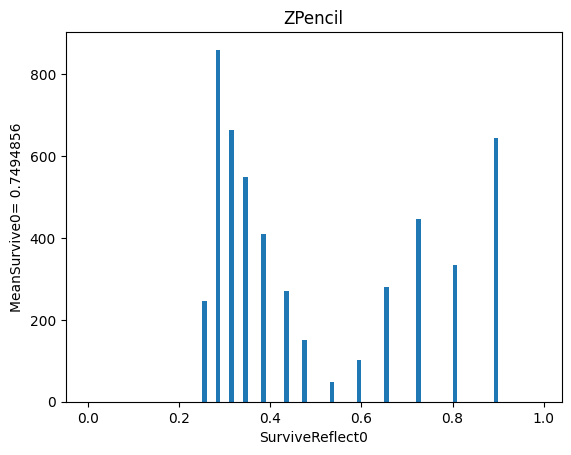

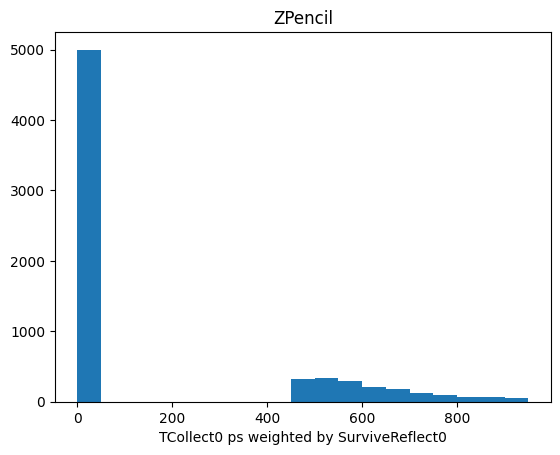

In [19]:
SurviveReflect0=np.reshape(SurviveReflect[0,:].numpy(),[NBins,NBins])
TCollect0=np.reshape(TCollect[0,:].numpy(),[NBins,NBins])
TMax=1000

SurviveBins=np.arange(0,1.0001,0.01)
plt.hist(SurviveReflect0.flatten(), bins=np.arange(0,1.,0.01))
print("MeanSurvive=0 " + str(SurviveReflect0.mean()))
plt.title("ZPencil" )
plt.ylabel("MeanSurvive0= " + str(SurviveReflect0.mean()))
plt.xlabel('SurviveReflect0')
plt.show()

TCollectBins=np.arange(0,TMax,50)
plt.hist(TCollect0.flatten(), bins=TCollectBins, weights=SurviveReflect0.flatten())
plt.title("ZPencil" )
plt.xlabel("TCollect0 ps weighted by SurviveReflect0")
plt.show()

ic| DetectXY.size(): torch.Size([1000, 96])


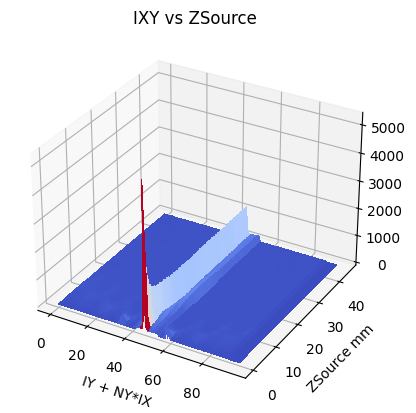

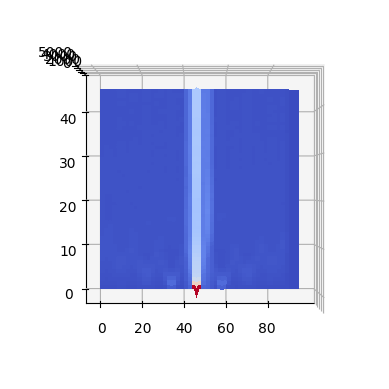

In [20]:
xedges=np.arange(0,1+DetectNX*DetectNY,1)
yedges=(ZSource[:,0]).numpy()
DetectXY=torch.zeros(NEvents,DetectNY*DetectNX)
ic(DetectXY.size())
#
for thisEvent in range(0,NEvents):
  thisXDetect=torch.floor_divide(XDetect[thisEvent,:]+(DX/2.),dX)
  thisIXDetect=thisXDetect.numpy()
  dT=50
  thisIYDetect=torch.floor_divide(YDetect[thisEvent,:],dY)
  thisIYDetect=thisIYDetect.numpy()
  thisIXYDetect=thisIYDetect+(DetectNY*thisIXDetect)
  thisSurviveReflect=SurviveReflect[thisEvent,:].numpy()
  thisDetectXY, thisXYedge= np.histogram(thisIXYDetect,bins=xedges,weights=thisSurviveReflect)
  DetectXY[thisEvent,:]=torch.tensor(thisDetectXY.flatten())

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

# Make data.
pX = np.arange(0, DetectNX*DetectNY, 1)
#pY = np.arange(0, NEvents, 1)
pY = (ZSource[:,0]).numpy()
XX, YY = np.meshgrid(pX, pY)
ZZ = DetectXY

# Plot the surface.
surf = ax.plot_surface(XX, YY, ZZ, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

plt.ylabel('ZSource mm')
plt.xlabel('IY + NY*IX')
plt.title('IXY vs ZSource')

ax = plt.figure().add_subplot(projection='3d')
ax.view_init(elev=90, azim=-90, roll=0)
surf = ax.plot_surface(XX, YY, ZZ, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
plt.show()



If RegularZ, display histograms of by IXY of events varying as a function of Z

ic| DetectXYT.size(): torch.Size([1000, 1920])


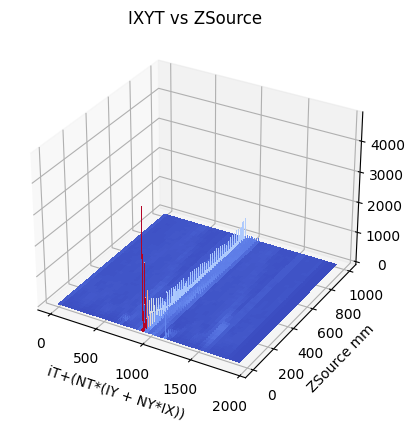

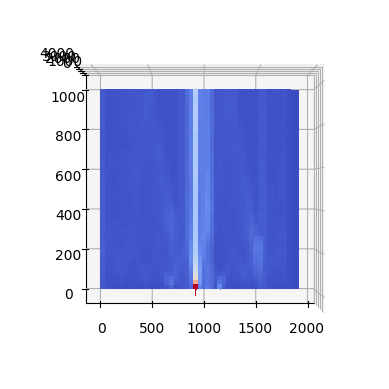

In [21]:
if (RegularZ):
  TMax=1000
  dT=50
  DetectNT=int(TMax/dT)
  xedges=np.arange(0,1+DetectNX*DetectNY*DetectNT,1)
  yedges=np.arange(0,1+NEvents,1)
  DetectXYT=torch.zeros(NEvents,DetectNT*DetectNY*DetectNX)
  ic(DetectXYT.size())
  #
  for thisEvent in range(0,NEvents):
    thisXDetect=torch.floor_divide(XDetect[thisEvent,:]+(DX/2.),dX)
    thisIXDetect=thisXDetect.numpy()
    thisIYDetect=torch.floor_divide(YDetect[thisEvent,:],dY)
    thisIYDetect=thisIYDetect.numpy()
    thisITDetect=torch.floor_divide(TCollect[thisEvent,:],dT)
    thisITDetect=thisITDetect.numpy()

    thisIXYTDetect=thisITDetect+(DetectNT*(thisIYDetect+(DetectNY*thisIXDetect)))
    thisSurviveReflect=SurviveReflect[thisEvent,:].numpy()
    thisDetectXYT, thisXYTedge= np.histogram(thisIXYTDetect,bins=xedges,weights=thisSurviveReflect)
    DetectXYT[thisEvent,:]=torch.tensor(thisDetectXYT.flatten())

  fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

  # Make data.
  pX = np.arange(0, DetectNX*DetectNY*DetectNT, 1)
  pY = np.arange(0, NEvents, 1)
  XX, YY = np.meshgrid(pX, pY)
  ZZ = DetectXYT
  #
  # Plot the surface.
  surf = ax.plot_surface(XX, YY, ZZ, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
  plt.ylabel('ZSource mm')
  plt.xlabel('iT+(NT*(IY + NY*IX))')
  plt.title('IXYT vs ZSource')
  plt.show()

  ax = plt.figure().add_subplot(projection='3d')
  ax.view_init(elev=90, azim=-90, roll=0)
  surf = ax.plot_surface(XX, YY, ZZ, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
  plt.show()

If RegularZ, display histograms of by IT of events varying as a function of Z



ic| DetectZT.size(): torch.Size([1000, 100])


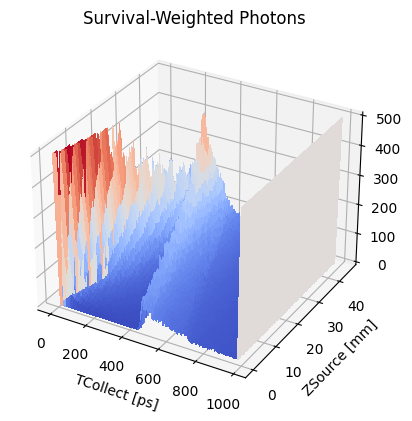

<ipython-input-22-5d72c7fcb6d8>:53: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('jet') # Get desired colormap - you can change this!


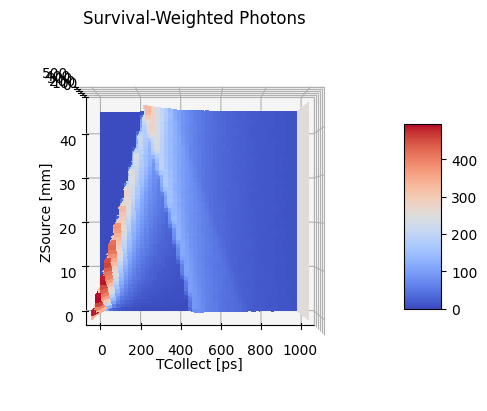

<ipython-input-22-5d72c7fcb6d8>:66: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('jet') # Get desired colormap - you can change this!


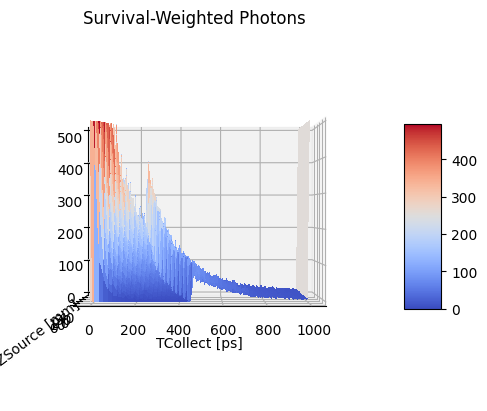

In [22]:
if (RegularZ):
  TMax=1000
  dT=10
  dZ=3
  DetectNZ=int(DZ/dZ)
  DetectNT=int(TMax/dT)
  #
  # xedges along T direction
  xedges=np.arange(0,1+DetectNT,1)
  # yedges along Z direction
  yedges=np.arange(0,1+NEvents,1)
  DetectZT=torch.zeros(NEvents,DetectNT)
  ic(DetectZT.size())
  #
  for thisEvent in range(0,NEvents):
    thisXDetect=torch.floor_divide(XDetect[thisEvent,:]+(DX/2.),dX)
    thisIXDetect=thisXDetect.numpy()
    thisIYDetect=torch.floor_divide(YDetect[thisEvent,:],dY)
    thisIYDetect=thisIYDetect.numpy()
    thisITDetect=torch.floor_divide(TCollect[thisEvent,:],dT)
    thisITDetect=thisITDetect.numpy()

    thisSurviveReflect=SurviveReflect[thisEvent,:].numpy()
    thisDetectT, thisDetectTedge= np.histogram(thisITDetect,bins=xedges,weights=thisSurviveReflect)
    DetectZT[thisEvent,:]=torch.tensor(thisDetectT.flatten())

  fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

  # Make data.
  pX = np.arange(0, 1000, dT)
  dZEvent=DZ/NEvents
  pY = np.arange(0, DZ, dZEvent)
  XX, YY = np.meshgrid(pX, pY)
  ZZ = np.minimum(500.,DetectZT)
  #
  # Plot the surface.
  surf = ax.plot_surface(XX, YY, ZZ, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
  plt.ylabel('ZSource [mm]')
  plt.xlabel('TCollect [ps]')
  plt.title('Survival-Weighted Photons')
  ax.set_zlim(0,500)
  plt.show()

  ax = plt.figure().add_subplot(projection='3d')
  ax.view_init(elev=90, azim=-90, roll=0)
  surf = ax.plot_surface(XX, YY, ZZ, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
  plt.ylabel('ZSource [mm]')
  plt.xlabel('TCollect [ps]')
  plt.title('Survival-Weighted Photons')
  from matplotlib import cm
  cmap = cm.get_cmap('jet') # Get desired colormap - you can change this!
  fig.colorbar(surf, shrink=0.5, aspect=5)
  ax.set_zlim(0,500.)
  plt.show()

  ax = plt.figure().add_subplot(projection='3d')
  ax.view_init(elev=0, azim=-90, roll=0)
  surf = ax.plot_surface(XX, YY, ZZ, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
  plt.ylabel('ZSource [mm]')
  plt.xlabel('TCollect [ps]')
  plt.title('Survival-Weighted Photons')
  from matplotlib import cm
  cmap = cm.get_cmap('jet') # Get desired colormap - you can change this!
  fig.colorbar(surf, shrink=0.5, aspect=5)
  ax.set_zlim(0,500.)
  plt.show()

Form digitized IX and IY outputs, and generate survival-weighted scatterplots from random photons from the ZPencil events


ic| thisDetectIXY: array([37., 37., 36., ..., 71., 36., 36.], dtype=float32)
ic| thisSurviveReflect: tensor([1.0000, 1.0000, 1.0000,  ..., 0.4783, 1.0000, 1.0000])
ic| aMaxThisDetectXY: 143
<ipython-input-23-c6783f346d8e>:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  SurviveMaxXY[thisEvent,:]=torch.tensor(thisSurviveReflect)
ic| RandTest.shape: (10000000,)
ic| RandSample.shape: (10000000,)
ic| ISample.size: 1029


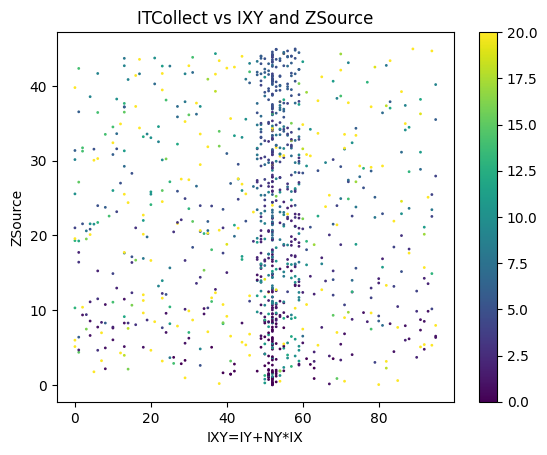

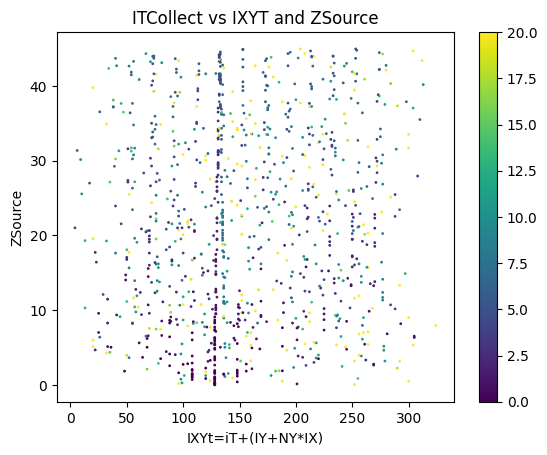

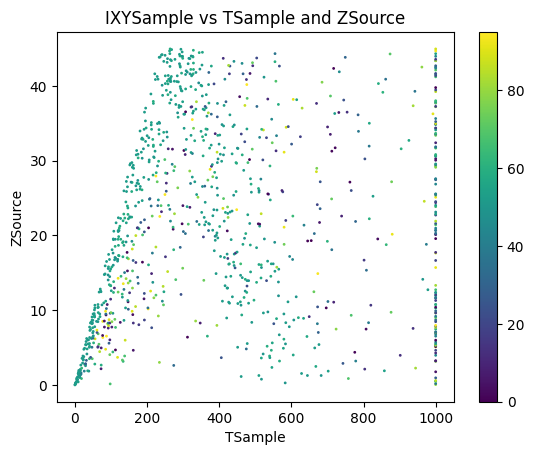

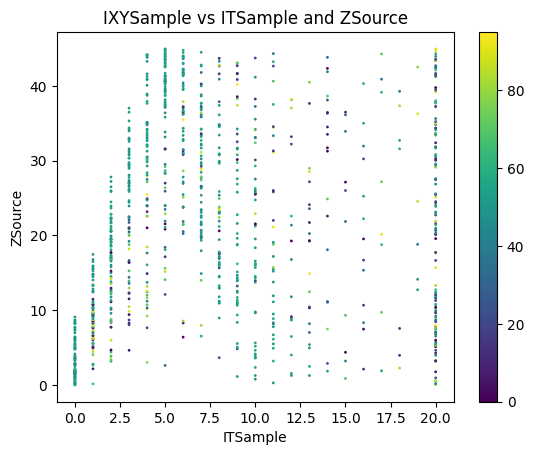

In [23]:
DetectNT=torch.tensor(int(1000/50))
SurviveMaxXY=torch.zeros(NEvents,NPhotons)
#
for thisEvent in range(0,NEvents):
  thisXDetect=torch.floor_divide(XDetect[thisEvent,:]+(DX/2.),dX)
  thisIXDetect=thisXDetect.numpy()
  thisYDetect=torch.floor_divide(YDetect[thisEvent,:]+(DY/2.),dY)
  thisIYDetect=thisYDetect.numpy()
  thisITDetect=torch.floor_divide(TCollect[thisEvent,:],50)
  thisITDetect=thisITDetect.numpy()
  thisSurviveReflect=SurviveReflect[thisEvent,:]
  thisDetectIXY=thisIXDetect+(DetectNX*thisIYDetect)
  aMaxThisDetectXY=np.argmax(thisDetectIXY)
  if(thisEvent==0):
    ic(thisDetectIXY)
    ic(thisSurviveReflect)
    ic(aMaxThisDetectXY)
  aMaxTest=torch.tensor(aMaxThisDetectXY==thisDetectIXY)
  SurviveMaxXY[thisEvent,:]=torch.tensor(thisSurviveReflect)

NSample=1000
FlatSurviveReflect=(SurviveMaxXY.flatten().numpy())
TotalSurviveReflect=FlatSurviveReflect.sum()
RandTest=(NSample/TotalSurviveReflect)*FlatSurviveReflect
ic(RandTest.shape)
#
rng = np.random.default_rng()
# Generate random floats uniformly distributed over the range [0, 1)
RandSample=rng.random(RandTest.size)
ic(RandSample.shape)
ISample=np.asarray(np.nonzero(RandSample<RandTest))
ic(ISample.size)

IX=(torch.floor_divide(XDetect+(DX/2.),dX).flatten()).numpy()
IXSample=IX[ISample]
IY=(torch.floor_divide(YDetect+(DY/2.),dY).flatten()).numpy()
IYSample=IY[ISample]
IXYSample=IYSample+(DetectNY*IXSample)
TMax=1000
dT=50
DetectNT=TMax/dT
IT=(torch.floor_divide(TCollect,dT).flatten()).numpy()
ITSample=IT[ISample]
flatTCollect=TCollect.flatten().numpy()
TSample=flatTCollect[ISample]
IXYTSample=ITSample+(DetectNT*IYSample+(DetectNY*IXSample))
flatZSource=ZSource.flatten().numpy()
ZSourceSample=flatZSource[ISample]

plt.scatter(IXYSample,ZSourceSample,c=ITSample,s=1)
plt.title('ITCollect vs IXY and ZSource' )
plt.xlabel('IXY=IY+NY*IX')
plt.ylabel('ZSource')
plt.colorbar()
plt.show()

plt.scatter(IXYTSample,ZSourceSample,c=ITSample,s=1)
plt.title('ITCollect vs IXYT and ZSource' )
plt.xlabel('IXYt=iT+(IY+NY*IX)')
plt.ylabel('ZSource')
plt.colorbar()
plt.show()

plt.scatter(TSample,ZSourceSample,c=IXYSample,s=1)
plt.title('IXYSample vs TSample and ZSource' )
plt.xlabel('TSample')
plt.ylabel('ZSource')
plt.colorbar()
plt.show()


plt.scatter(ITSample,ZSourceSample,c=IXYSample,s=1)
plt.title('IXYSample vs ITSample and ZSource' )
plt.xlabel('ITSample')
plt.ylabel('ZSource')
plt.colorbar()
plt.show()

Form digitized IX and  IY outputs, and generate survival-weighted scatterplots from random photons from the ZPencil events that were detected within the IXY channel that had peak occupancy for that event


ic| thisDetectIXY: array([37., 37., 36., ..., 71., 36., 36.], dtype=float32)
ic| thisSurviveReflect: tensor([1.0000, 1.0000, 1.0000,  ..., 0.4783, 1.0000, 1.0000])
ic| aMaxThisDetectXY: 143
<ipython-input-24-c6783f346d8e>:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  SurviveMaxXY[thisEvent,:]=torch.tensor(thisSurviveReflect)
ic| RandTest.shape: (10000000,)
ic| RandSample.shape: (10000000,)
ic| ISample.size: 1002


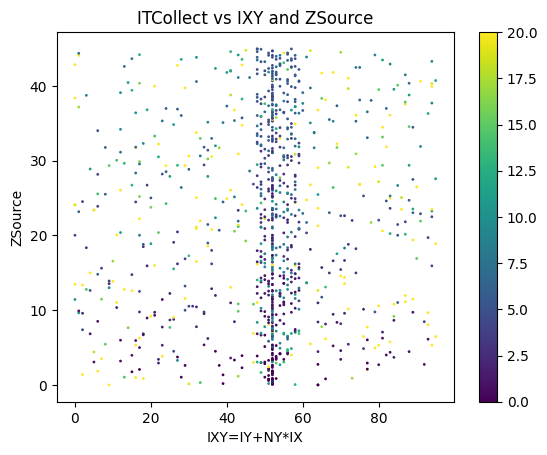

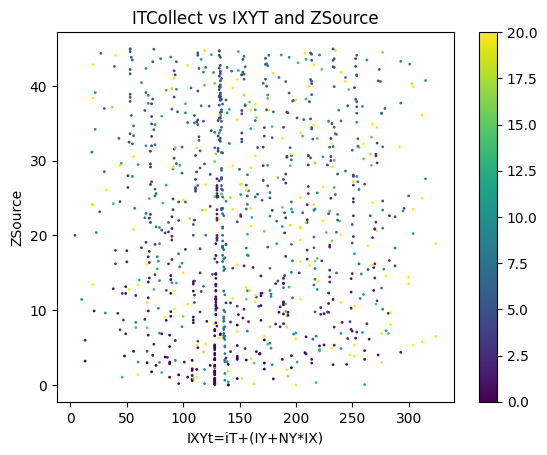

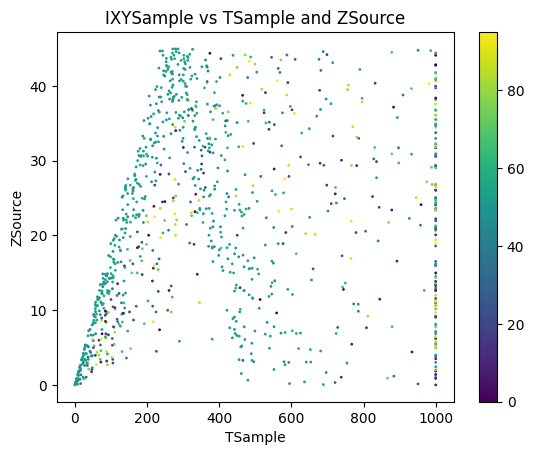

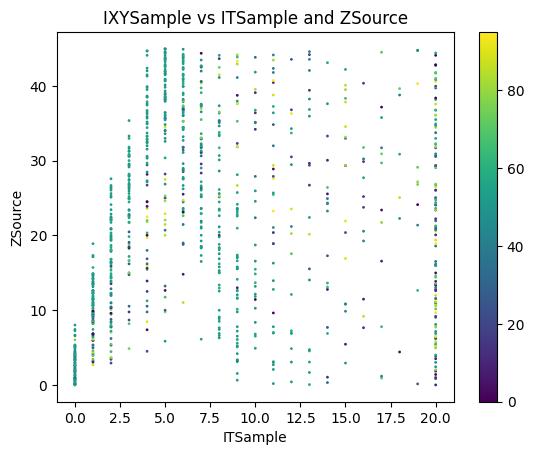

In [24]:
DetectNT=torch.tensor(int(1000/50))
SurviveMaxXY=torch.zeros(NEvents,NPhotons)
#
for thisEvent in range(0,NEvents):
  thisXDetect=torch.floor_divide(XDetect[thisEvent,:]+(DX/2.),dX)
  thisIXDetect=thisXDetect.numpy()
  thisYDetect=torch.floor_divide(YDetect[thisEvent,:]+(DY/2.),dY)
  thisIYDetect=thisYDetect.numpy()
  thisITDetect=torch.floor_divide(TCollect[thisEvent,:],50)
  thisITDetect=thisITDetect.numpy()
  thisSurviveReflect=SurviveReflect[thisEvent,:]
  thisDetectIXY=thisIXDetect+(DetectNX*thisIYDetect)
  aMaxThisDetectXY=np.argmax(thisDetectIXY)
  if(thisEvent==0):
    ic(thisDetectIXY)
    ic(thisSurviveReflect)
    ic(aMaxThisDetectXY)
  aMaxTest=torch.tensor(aMaxThisDetectXY==thisDetectIXY)
  SurviveMaxXY[thisEvent,:]=torch.tensor(thisSurviveReflect)

NSample=1000
FlatSurviveReflect=(SurviveMaxXY.flatten().numpy())
TotalSurviveReflect=FlatSurviveReflect.sum()
RandTest=(NSample/TotalSurviveReflect)*FlatSurviveReflect
ic(RandTest.shape)
#
rng = np.random.default_rng()
# Generate random floats uniformly distributed over the range [0, 1)
RandSample=rng.random(RandTest.size)
ic(RandSample.shape)
ISample=np.asarray(np.nonzero(RandSample<RandTest))
ic(ISample.size)

IX=(torch.floor_divide(XDetect+(DX/2.),dX).flatten()).numpy()
IXSample=IX[ISample]
IY=(torch.floor_divide(YDetect+(DY/2.),dY).flatten()).numpy()
IYSample=IY[ISample]
IXYSample=IYSample+(DetectNY*IXSample)
TMax=1000
dT=50
DetectNT=TMax/dT
IT=(torch.floor_divide(TCollect,dT).flatten()).numpy()
ITSample=IT[ISample]
flatTCollect=TCollect.flatten().numpy()
TSample=flatTCollect[ISample]
IXYTSample=ITSample+(DetectNT*IYSample+(DetectNY*IXSample))
flatZSource=ZSource.flatten().numpy()
ZSourceSample=flatZSource[ISample]

plt.scatter(IXYSample,ZSourceSample,c=ITSample,s=1)
plt.title('ITCollect vs IXY and ZSource' )
plt.xlabel('IXY=IY+NY*IX')
plt.ylabel('ZSource')
plt.colorbar()
plt.show()

plt.scatter(IXYTSample,ZSourceSample,c=ITSample,s=1)
plt.title('ITCollect vs IXYT and ZSource' )
plt.xlabel('IXYt=iT+(IY+NY*IX)')
plt.ylabel('ZSource')
plt.colorbar()
plt.show()

plt.scatter(TSample,ZSourceSample,c=IXYSample,s=1)
plt.title('IXYSample vs TSample and ZSource' )
plt.xlabel('TSample')
plt.ylabel('ZSource')
plt.colorbar()
plt.show()


plt.scatter(ITSample,ZSourceSample,c=IXYSample,s=1)
plt.title('IXYSample vs ITSample and ZSource' )
plt.xlabel('ITSample')
plt.ylabel('ZSource')
plt.colorbar()
plt.show()

Form digitized IX and IY outputs, then generate and store survival-weighted 2D histograms while looping over events.

Display the digitized IXY histogram for the sum of all events

ic| Detect2Dbins: (array([0, 1, 2, 3, 4, 5, 6, 7, 8]),
                   array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12]))
ic| DetectXY.size(): torch.Size([1000, 12, 8])
ic| thisIXDetect.shape: (10000,)
ic| thisIYDetect.shape: (10000,)
ic| thisSurviveReflect.shape: (10000,)
ic| DetectXY.shape: torch.Size([1000, 12, 8])
ic| DetectXY0.shape: (12, 8)
<ipython-input-25-963530818821>:41: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('jet') # Get desired colormap - you can change this!


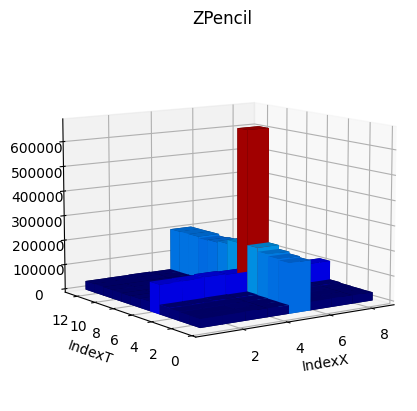

In [25]:
xedges=np.arange(0,1+DetectNX,1)
yedges=np.arange(0,1+DetectNY,1)
Detect2Dbins=(xedges,yedges)
ic(Detect2Dbins)
DetectXY=torch.zeros(NEvents,DetectNY,DetectNX)
ic(DetectXY.size())
#
for thisEvent in range(0,NEvents):
  thisYDetect=torch.floor_divide(XDetect[thisEvent,:]+(DX/2.),dX)
  thisIXDetect=thisXDetect.numpy()
  if (thisEvent==0):
     ic(thisIXDetect.shape)
  thisIYDetect=torch.floor_divide(YDetect[thisEvent,:]+(DY/2.),dY)
  thisIYDetect=thisIYDetect.numpy()
  if (thisEvent==0):
    ic(thisIYDetect.shape)
  thisSurviveReflect=SurviveReflect[thisEvent,:].numpy()
  if (thisEvent==0):
    ic(thisSurviveReflect.shape)
  thisDetectXY, thisXedge, thisYedge= np.histogram2d(thisIXDetect,thisIYDetect,bins=Detect2Dbins,weights=thisSurviveReflect)
  DetectXY[thisEvent,:,:]=torch.transpose(torch.tensor(thisDetectXY),0,1)

ic(DetectXY.shape)
DetectXY0=torch.sum(DetectXY,0)
DetectXY0=DetectXY0.numpy()
ic(DetectXY0.shape)

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
#ax = fig.add_subplot(132, title='DetectH', aspect='equal')
xpos, ypos = np.meshgrid(xedges[:-1]+xedges[1:], yedges[:-1]+yedges[1:])

xpos = xpos.flatten()/2.
ypos = ypos.flatten()/2.
zpos = np.zeros_like (xpos)

Hdx = xedges [1] - xedges [0]
Hdy = yedges [1] - yedges [0]
Hdz = DetectXY0.flatten()

from matplotlib import cm
cmap = cm.get_cmap('jet') # Get desired colormap - you can change this!
#plt.colormaps['jet']
max_height = np.max(Hdz)   # get range of colorbars so we can normalize
min_height = np.min(Hdz)
# scale each z to [0,1], and get their rgb values
rgba = [cmap((k-min_height)/max_height) for k in Hdz]


ax.bar3d(xpos, ypos, zpos, Hdx, Hdy, Hdz, color=rgba, zsort='average')
plt.xlabel("IndexX")
plt.ylabel("IndexT")
plt.title('ZPencil')
ax.view_init(elev=10, azim=235, roll=0)
#plt.savefig("Your_title_goes_here")
plt.show()

Form digitized IX and IT outputs, then generate and store survival-weighted 2D histograms while looping over events.

Display the digitized IXT histogram for the sum of all events

ic| Detect2Dbins: (array([0, 1, 2, 3, 4, 5, 6, 7, 8]),
                   array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
                         17, 18, 19, 20]))
ic| DetectXT.size(): torch.Size([1000, 20, 8])
ic| thisIXDetect.shape: (10000,)
ic| thisITDetect.shape: (10000,)
ic| thisSurviveReflect.shape: (10000,)
ic| DetectXT.shape: torch.Size([1000, 20, 8])
ic| DetectXT0.shape: (20, 8)
<ipython-input-26-54474a861dc1>:44: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('jet') # Get desired colormap - you can change this!


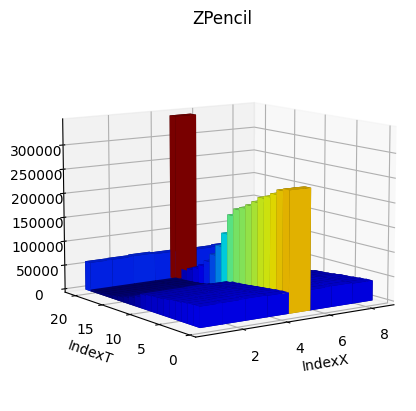

In [26]:
xedges=np.arange(0,1+DetectNX,1)
dT=50
DetectNT=int(1000/50)
yedges=np.arange(0,1+DetectNT,1)
Detect2Dbins=(xedges,yedges)
ic(Detect2Dbins)
DetectNT=torch.tensor(int(1000/50))
DetectXT=torch.zeros(NEvents,DetectNT,DetectNX)
ic(DetectXT.size())
#
for thisEvent in range(0,NEvents):
  thisYDetect=torch.floor_divide(XDetect[thisEvent,:]+(DX/2.),dX)
  thisIXDetect=thisXDetect.numpy()
  if (thisEvent==0):
     ic(thisIXDetect.shape)
  thisITDetect=torch.floor_divide(TCollect[thisEvent,:],50)
  thisITDetect=thisITDetect.numpy()
  if (thisEvent==0):
    ic(thisITDetect.shape)
  thisSurviveReflect=SurviveReflect[thisEvent,:].numpy()
  if (thisEvent==0):
    ic(thisSurviveReflect.shape)
  thisDetectXT, thisXedge, thisTedge= np.histogram2d(thisIXDetect,thisITDetect,bins=Detect2Dbins,weights=thisSurviveReflect)
  DetectXT[thisEvent,:,:]=torch.transpose(torch.tensor(thisDetectXT),0,1)

ic(DetectXT.shape)
DetectXT0=torch.sum(DetectXT,0)
DetectXT0=DetectXT0.numpy()
ic(DetectXT0.shape)

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
#ax = fig.add_subplot(132, title='DetectH', aspect='equal')
xpos, ypos = np.meshgrid(xedges[:-1]+xedges[1:], yedges[:-1]+yedges[1:])

xpos = xpos.flatten()/2.
ypos = ypos.flatten()/2.
zpos = np.zeros_like (xpos)

Hdx = xedges [1] - xedges [0]
Hdy = yedges [1] - yedges [0]
Hdz = DetectXT0.flatten()

from matplotlib import cm
cmap = cm.get_cmap('jet') # Get desired colormap - you can change this!
#plt.colormaps['jet']
max_height = np.max(Hdz)   # get range of colorbars so we can normalize
min_height = np.min(Hdz)
# scale each z to [0,1], and get their rgb values
rgba = [cmap((k-min_height)/max_height) for k in Hdz]


ax.bar3d(xpos, ypos, zpos, Hdx, Hdy, Hdz, color=rgba, zsort='average')
plt.xlabel("IndexX")
plt.ylabel("IndexT")
plt.title('ZPencil')
ax.view_init(elev=10, azim=235, roll=0)
#plt.savefig("Your_title_goes_here")
plt.show()

Form digitized IY and IT outputs, then generate and store survival-weighted 2D histograms while looping over events.

Display the digitized YT histogram for the sum of all events

ic| Detect2Dbins: (array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12]),
                   array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
                         17, 18, 19, 20]))
ic| DetectYT.size(): torch.Size([1000, 20, 12])
ic| thisIYDetect.shape: (10000,)
ic| thisITDetect.shape: (10000,)
ic| thisSurviveReflect.shape: (10000,)
ic| DetectYT.shape: torch.Size([1000, 20, 12])
ic| DetectYT0.shape: (20, 12)
<ipython-input-27-b2dfd699f3d3>:44: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('jet') # Get desired colormap - you can change this!


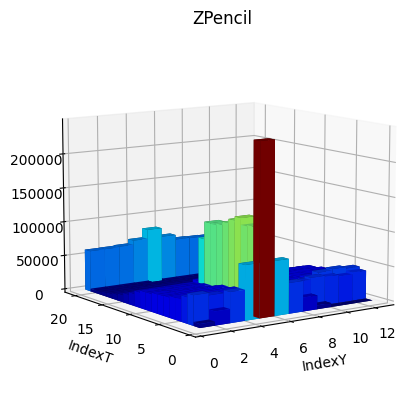

In [27]:
xedges=np.arange(0,1+DetectNY,1)
dT=50
DetectNT=int(1000/50)
yedges=np.arange(0,1+DetectNT,1)
Detect2Dbins=(xedges,yedges)
ic(Detect2Dbins)
DetectNT=torch.tensor(int(1000/50))
DetectYT=torch.zeros(NEvents,DetectNT,DetectNY)
ic(DetectYT.size())
#
for thisEvent in range(0,NEvents):
  thisYDetect=torch.floor_divide(YDetect[thisEvent,:]+(DY/2.),dY)
  thisIYDetect=thisYDetect.numpy()
  if (thisEvent==0):
     ic(thisIYDetect.shape)
  thisITDetect=torch.floor_divide(TCollect[thisEvent,:],50)
  thisITDetect=thisITDetect.numpy()
  if (thisEvent==0):
    ic(thisITDetect.shape)
  thisSurviveReflect=SurviveReflect[thisEvent,:].numpy()
  if (thisEvent==0):
    ic(thisSurviveReflect.shape)
  thisDetectYT, thisXedge, thisTedge= np.histogram2d(thisIYDetect,thisITDetect,bins=Detect2Dbins,weights=thisSurviveReflect)
  DetectYT[thisEvent,:,:]=torch.transpose(torch.tensor(thisDetectYT),0,1)

ic(DetectYT.shape)
DetectYT0=torch.sum(DetectYT,0)
DetectYT0=DetectYT0.numpy()
ic(DetectYT0.shape)

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
#ax = fig.add_subplot(132, title='DetectH', aspect='equal')
xpos, ypos = np.meshgrid(xedges[:-1]+xedges[1:], yedges[:-1]+yedges[1:])

xpos = xpos.flatten()/2.
ypos = ypos.flatten()/2.
zpos = np.zeros_like (xpos)

Hdx = xedges [1] - xedges [0]
Hdy = yedges [1] - yedges [0]
Hdz = DetectYT0.flatten()

from matplotlib import cm
cmap = cm.get_cmap('jet') # Get desired colormap - you can change this!
#plt.colormaps['jet']
max_height = np.max(Hdz)   # get range of colorbars so we can normalize
min_height = np.min(Hdz)
# scale each z to [0,1], and get their rgb values
rgba = [cmap((k-min_height)/max_height) for k in Hdz]


ax.bar3d(xpos, ypos, zpos, Hdx, Hdy, Hdz, color=rgba, zsort='average')
plt.xlabel("IndexY")
plt.ylabel("IndexT")
plt.title('ZPencil')
ax.view_init(elev=10, azim=235, roll=0)
#plt.savefig("Your_title_goes_here")
plt.show()

Looping over all events, generate a set of histograms for the XYT data, and store them.

Generate and display a 2D display from XY,T for the sum of all events.

ic| DetectXYT.size(): torch.Size([1000, 20, 96])
ic| thisIXDetect.shape: (10000,)
ic| thisIYDetect.shape: (10000,)
ic| thisITDetect.shape: (10000,)
ic| thisSurviveReflect.shape: (10000,)
ic| DetectXYT0.shape: (20, 96)
ic| xedges.shape: (97,)
ic| yedges.shape: (21,)
ic| HX.shape: (21, 97)
ic| HY.shape: (21, 97)
ic| DetectXYT0.shape: (20, 96)


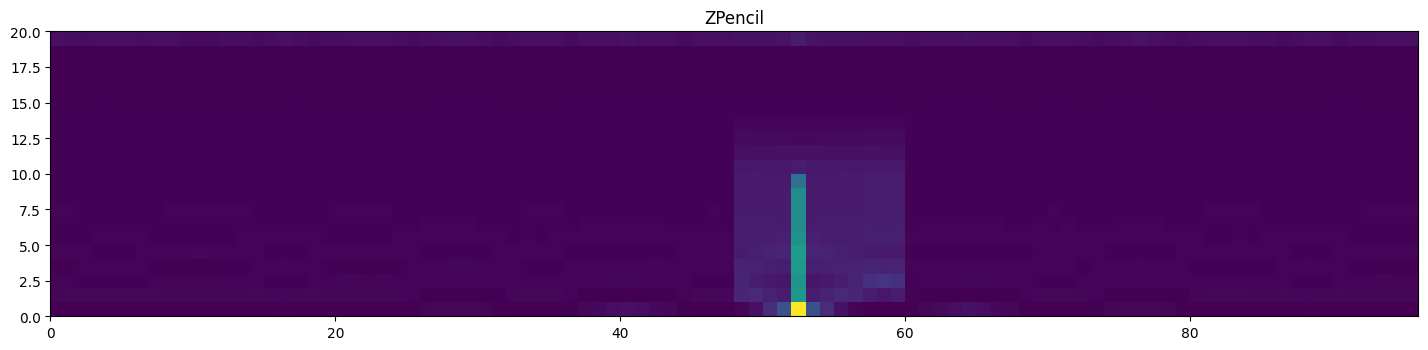

ic| EventData.shape: (8, 12, 20)
ic| EventData[:,5,2]: array([ 3536.0999 , 18864.191  ,  1478.1931 , 15395.754  ,  1227.9237 ,
                              3065.3792 ,   682.155  ,   495.31116], dtype=float32)


array([ 3536.0999 , 18864.191  ,  1478.1931 , 15395.754  ,  1227.9237 ,
        3065.3792 ,   682.155  ,   495.31116], dtype=float32)

In [28]:
DetectXYT=torch.zeros(NEvents,DetectNT,DetectNX*DetectNY)
ic(DetectXYT.size())
xedges=np.arange(0,1+DetectNX*DetectNY,1)
yedges=np.arange(0,1+DetectNT,1)
Detect2Dbins=(xedges,yedges)

for thisEvent in range(0,NEvents):
  thisXDetect=torch.floor_divide(XDetect[thisEvent,:]+(DX/2.),dX)
  thisIXDetect=thisXDetect.numpy()
  if (thisEvent==0):
     ic(thisIXDetect.shape)
  thisYDetect=torch.floor_divide(YDetect[thisEvent,:]+(DY/2.),dY)
  thisIYDetect=thisYDetect.numpy()
  if (thisEvent==0):
     ic(thisIYDetect.shape)
  thisIXYDetect=thisIYDetect+(DetectNY*thisIXDetect)
  #
  thisITDetect=torch.floor_divide(TCollect[thisEvent,:],dT)
  thisITDetect=thisITDetect.numpy()
  if (thisEvent==0):
    ic(thisITDetect.shape)
  thisSurviveReflect=SurviveReflect[thisEvent,:].numpy()
  if (thisEvent==0):
    ic(thisSurviveReflect.shape)
  thisDetectXYT, thisXedge, thisTedge= np.histogram2d(thisIXYDetect,thisITDetect,bins=Detect2Dbins,weights=thisSurviveReflect)
  DetectXYT[thisEvent,:,:]=torch.transpose(torch.tensor(thisDetectXYT),0,1)

DetectXYT0=(torch.sum(DetectXYT,0).numpy()).reshape([DetectNT,DetectNX*DetectNY])

ic(DetectXYT0.shape)

fig = plt.figure(figsize=(60, 30))

ThisTitle='ZPencil'

ax = fig.add_subplot(132, title=ThisTitle,
        aspect='equal')
ic(xedges.shape)
ic(yedges.shape)
HX, HY = np.meshgrid(xedges, yedges)
ic(HX.shape)
ic(HY.shape)
ic(DetectXYT0.shape)

ax.pcolormesh(HX, HY, DetectXYT0)
plt.show()

EventData=np.reshape(DetectXYT0,[DetectNX,DetectNY,DetectNT])
ic(EventData.shape)
ic(EventData[:,5,2])

Report mean photon survival probability for the first event.

Display histogram of Reflection Survival Likelihood for the photons in the first even.

Also display histogram of Reflection Survival-weighted photon collection times

MeanSurvive=0 0.7494856


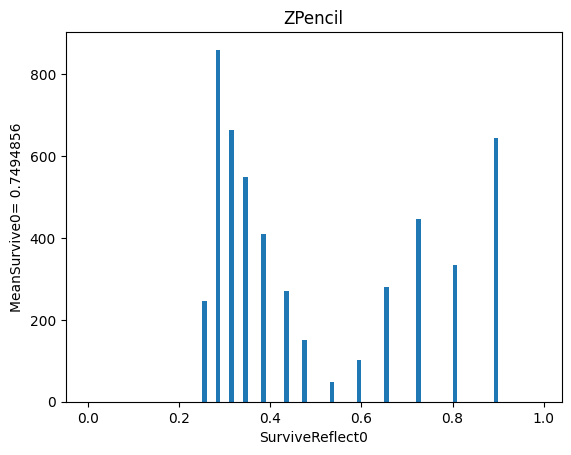

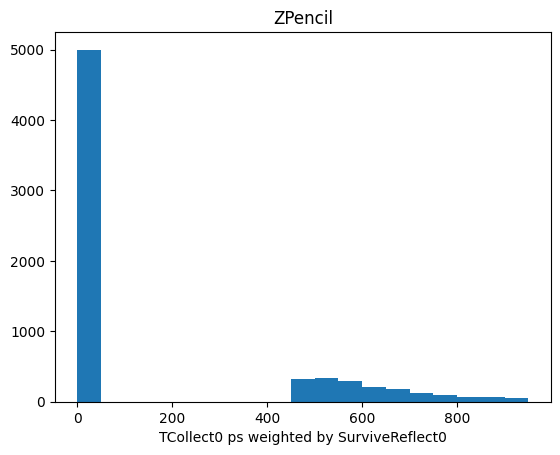

In [29]:
SurviveReflect0=np.reshape(SurviveReflect[0,:].numpy(),[NBins,NBins])
TCollect0=np.reshape(TCollect[0,:].numpy(),[NBins,NBins])
TMax=1000

SurviveBins=np.arange(0,1.0001,0.01)
plt.hist(SurviveReflect0.flatten(), bins=np.arange(0,1.,0.01))
print("MeanSurvive=0 " + str(SurviveReflect0.mean()))
plt.title("ZPencil" )
plt.ylabel("MeanSurvive0= " + str(SurviveReflect0.mean()))
plt.xlabel('SurviveReflect0')
plt.show()

TCollectBins=np.arange(0,TMax,50)
plt.hist(TCollect0.flatten(), bins=TCollectBins, weights=SurviveReflect0.flatten())
plt.title("ZPencil" )
plt.xlabel("TCollect0 ps weighted by SurviveReflect0")
plt.show()

Looping over all events, generate output Data tensor for each event

Data.size=[NEvents,DetectNX,DetectNY,DetectNT)

Digitized Detector Indices: [IT,IX,IY]

Digitized Z Source Position: [IZ]

Data [NT=20,NX=8,NY=12] and dT=50 [ps] currently

In [30]:
ic(NPhotons)
ic(NEvents)
#
# Digitize with perfect modulation transfer function (MTF) and histogram
IEvent=torch.reshape(torch.arange(0,NEvents).repeat(NPhotons),[NEvents, NPhotons])
#ic(IEvent.size())
#ic(IEvent[0][0])
#ic(IEvent[0][1])
#ic(IEvent[1][0])

IXDetect=(torch.floor_divide((DX/2.)+XDetect,dX)).int()
ic(IXDetect.size())
IYDetect=(torch.floor_divide((DY/2.)+YDetect,dY)).int()
dZ=3.
IZDetect=(torch.floor_divide(ZSource,dZ)).int()
ITDetect=(torch.floor_divide(TCollect,50)).int()
DetectNT=torch.tensor(int(1000/50))

NHBins_Htyx=((DetectNT*DetectNY*DetectNX).int()).numpy()
NHBins_Hty=((DetectNT*DetectNY).int()).numpy()
DetectNT=int(1000/50)
NHBins_Htx=int(DetectNT*DetectNX)
NHBins_Hyx=int(DetectNY*DetectNX)
NHBins_Ht=DetectNT
NHBins_Hy=DetectNY
NHBins_Hx=DetectNX
#
xedges=np.arange(0,1+DetectNT,1)
yedges=np.arange(0,1+DetectNY,1)
HBins_Hty=(xedges,yedges)
xedges=np.arange(0,1+DetectNT,1)
yedges=np.arange(0,1+DetectNX,1)
HBins_Htx=(xedges,yedges)
xedges=np.arange(0,1+DetectNY,1)
yedges=np.arange(0,1+DetectNX,1)
HBins_Hyx=(xedges,yedges)

#IDetect=ITDetect+DetectNT*(IYDetect+DetectNY*(IXDetect+DetectNX*IEvent))
Data=torch.zeros(NEvents,DetectNX,DetectNY,DetectNT)
ic(Data.size())

for iEvent in range(0,NEvents):
  #Collect floating point data for this event
  thisTDetect=ITDetect[iEvent,:]
  thisYDetect=IYDetect[iEvent,:]
  thisXDetect=IXDetect[iEvent,:]
  #
  # Form index for histogramming
  #thisDetect=(thisTDetect+DetectNT*(thisYDetect+DetectNY*thisXDetect))
  #thisDetect1=thisTDetect
  #thisDetect2=np.add(thisYDetect,DetectNY*thisDetect1)
  #thisDetect_tyx=np.add(thisXDetect,DetectNX*thisDetect2)
  thisDetect1=thisXDetect
  thisDetect2=np.add(thisYDetect,DetectNY*thisDetect1)
  thisDetect_tyx=np.add(thisTDetect,DetectNT*thisDetect2)
  #
  thisDetect_ty=np.add(thisTDetect,DetectNT*thisYDetect)
  thisDetect_tx=np.add(thisTDetect,DetectNT*thisXDetect)
  thisDetect_yx=np.add(thisYDetect,DetectNY*thisXDetect)
  #
  thisSurviveReflect=(SurviveReflect[iEvent,:])
  thisSurviveReflect=thisSurviveReflect.numpy()
  Detect_Htyx, Htyx_edge = np.histogram(thisDetect_tyx, bins=NHBins_Htyx, weights=thisSurviveReflect)
  #
  thisData=np.reshape(Detect_Htyx,[DetectNT,DetectNY,DetectNX])
  Data[iEvent,:,:,:]=torch.tensor(np.reshape(thisData,[DetectNX,DetectNY,DetectNT]))

ic(Data.size())
print("Data.size=[NEvents,NX,NY,NT]")

ic| NPhotons: 10000
ic| NEvents: 1000
ic| IXDetect.size(): torch.Size([1000, 10000])
ic| Data.size(): torch.Size([1000, 8, 12, 20])
ic| Data.size(): torch.Size([1000, 8, 12, 20])


Data.size=[NEvents,NX,NY,NT]


Form digitized IX, IY, IZ and iT outputs, then generate and store survival-weighted 2D histograms while looping over events.

Display the digitized IZT histogram for the sum of all events

ic| Detect2Dbins: (array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12]),
                   array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
                         17, 18, 19, 20]))
ic| DetectYT.size(): torch.Size([1000, 20, 12])
ic| thisIYDetect.shape: (10000,)
ic| thisITDetect.shape: (10000,)
ic| thisSurviveReflect.shape: (10000,)
ic| DetectYT.shape: torch.Size([1000, 20, 12])
ic| DetectYT0.shape: (20, 12)
<ipython-input-31-b2dfd699f3d3>:44: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('jet') # Get desired colormap - you can change this!


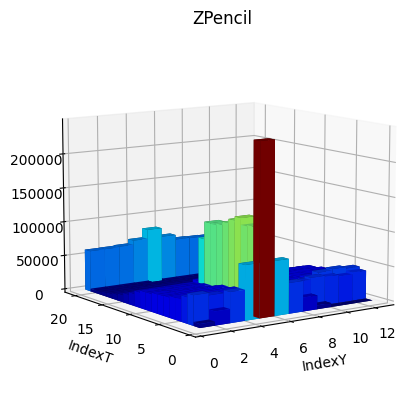

In [31]:
xedges=np.arange(0,1+DetectNY,1)
dT=50
DetectNT=int(1000/50)
yedges=np.arange(0,1+DetectNT,1)
Detect2Dbins=(xedges,yedges)
ic(Detect2Dbins)
DetectNT=torch.tensor(int(1000/50))
DetectYT=torch.zeros(NEvents,DetectNT,DetectNY)
ic(DetectYT.size())
#
for thisEvent in range(0,NEvents):
  thisYDetect=torch.floor_divide(YDetect[thisEvent,:]+(DY/2.),dY)
  thisIYDetect=thisYDetect.numpy()
  if (thisEvent==0):
     ic(thisIYDetect.shape)
  thisITDetect=torch.floor_divide(TCollect[thisEvent,:],50)
  thisITDetect=thisITDetect.numpy()
  if (thisEvent==0):
    ic(thisITDetect.shape)
  thisSurviveReflect=SurviveReflect[thisEvent,:].numpy()
  if (thisEvent==0):
    ic(thisSurviveReflect.shape)
  thisDetectYT, thisXedge, thisTedge= np.histogram2d(thisIYDetect,thisITDetect,bins=Detect2Dbins,weights=thisSurviveReflect)
  DetectYT[thisEvent,:,:]=torch.transpose(torch.tensor(thisDetectYT),0,1)

ic(DetectYT.shape)
DetectYT0=torch.sum(DetectYT,0)
DetectYT0=DetectYT0.numpy()
ic(DetectYT0.shape)

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
#ax = fig.add_subplot(132, title='DetectH', aspect='equal')
xpos, ypos = np.meshgrid(xedges[:-1]+xedges[1:], yedges[:-1]+yedges[1:])

xpos = xpos.flatten()/2.
ypos = ypos.flatten()/2.
zpos = np.zeros_like (xpos)

Hdx = xedges [1] - xedges [0]
Hdy = yedges [1] - yedges [0]
Hdz = DetectYT0.flatten()

from matplotlib import cm
cmap = cm.get_cmap('jet') # Get desired colormap - you can change this!
#plt.colormaps['jet']
max_height = np.max(Hdz)   # get range of colorbars so we can normalize
min_height = np.min(Hdz)
# scale each z to [0,1], and get their rgb values
rgba = [cmap((k-min_height)/max_height) for k in Hdz]


ax.bar3d(xpos, ypos, zpos, Hdx, Hdy, Hdz, color=rgba, zsort='average')
plt.xlabel("IndexY")
plt.ylabel("IndexT")
plt.title('ZPencil')
ax.view_init(elev=10, azim=235, roll=0)
#plt.savefig("Your_title_goes_here")
plt.show()